# Loading in the data and some model musings

Let's first load in the data and then get the basic matching nets architecture up and going.  One thing that seems like it could be fun to play with here is adding a siamese kind of constraint to the model on the batch.

So when we generate a batch, make sure that we have some same and different images for the test images (balanced).  With the loss for matching nets, we have already placed a loss that passes gradients up to the parameters of the encoder.  But the encoder could also be viewed as part of a larger siamese network and we could add the binary siamese loss to the batch loss as well.  

Would this kind of blending of models be useful?  Provide a performance enhancement?

On some level, it would at least seem to regularize by demanding the model be proficient at (or adapt to) different tasks.  It would also seem to "expand" the dataset a little bit by augmenting the comparisons we make.  Together with traditional data augmentation, how well would this kind of approach work? 

Let's load in the data

In [9]:
import numpy as np
import pandas as pd

# Set seed
np.random.seed(0)

# Load the background dataset. X_background contains the background
# images and y_background class information.
train_npz_file = np.load('../data/processed/train_28.npz')
X_background, y_background = train_npz_file['arr_0'], train_npz_file['arr_1']

# Load the evaluation dataset. X_evaluation contains the background
# images and y_evaluation class information.
test_npz_file = np.load('../data/processed/test_28.npz')
X_evaluation, y_evaluation = test_npz_file['arr_0'], test_npz_file['arr_1']

# Put the class information in pandas arrays for ease of exploration
# and constrained sampling.  
y_background_pd = pd.DataFrame(
                    data=y_background, 
                    columns=['Alphabet', 'Character', 'Drawer']
    )
y_evaluation_pd = pd.DataFrame(
                    data=y_evaluation, 
                    columns=['Alphabet', 'Character', 'Drawer']
    )

# Check shapes of images.
print(X_background.shape, y_background.shape, X_evaluation.shape, y_evaluation.shape)

(19280, 28, 28) (19280, 3) (13180, 28, 28) (13180, 3)


And split the background set randomly into training and testing sets.

In [10]:
# Further split the background set into training and validation sets
# by reserving a fraction of the 20 drawers for validation:
# --> first isolate the unique drawers (there are 20 of these)
# --> randomly select 16 of these to send to training set and the remaining 4 to validation 
drawers = y_background_pd.Drawer.unique()
trn_drawers = np.random.choice(drawers, 16, replace=False)
trn_inds = y_background_pd.Drawer.isin(trn_drawers)
X_trn, y_trn = X_background[trn_inds], y_background[trn_inds]
X_val, y_val = X_background[~trn_inds], y_background[~trn_inds]

Load in some custom utilities and create one-shot data loaders for each of the training, validation and testing datasets.

In [11]:
import os
import sys
new_path = os.getcwd() + '/../src'
if new_path not in sys.path:
    sys.path.append(new_path)

%load_ext autoreload
%autoreload 2

from data.data_utils import OneShotGenerator
from data.data_utils import plot_oneshot_task

TrnData = OneShotGenerator(X_trn, y_trn)
ValData = OneShotGenerator(X_val, y_val)
TstData = OneShotGenerator(X_evaluation, y_evaluation)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now try generating and plotting a one-shot task

In [12]:
x_pairs, y_pairs = TrnData.generate_one_shot()

print('Below is a one-shot sample of characters from the {} alphabet.'.format(
                        y_pairs[0].Alphabet.iloc[0]) + \
      ' The sampled characters are at the same positions in both test and support plots.\n')
pairs = [x_pairs[0].reshape(20, 105, 105, 1), x_pairs[1].reshape(20, 105, 105, 1)]
# Note, the plot may fail sometimes since the training data has alphabets with less than
# 20 characters.  In this case, the OneShotGenerator samples test and support examples of
# the entire alphabet (from two randomly selected drawers).  The plot_oneshot (which was
# disigned to plot 20-way tasks) fails in this case.  Re-running the cell should generate
# a new sample that works.
plot_oneshot_task(pairs)

Below is a one-shot sample of characters from the Balinese alphabet. The sampled characters are at the same positions in both test and support plots.



ValueError: cannot reshape array of size 15680 into shape (20,105,105,1)

# Generating flexible matching networks

We want to be able to specify encoder parameters and output/train a matching network.   Maybe sync this up with bayesian optimization so that we can scan over a few different architectures and parameter choices and find something that works well on the data.  

Maybe the best place to start is to try to reproduce the architecture from the original paper and see if we can get matching networks matching their results.  Then see if we can improve on this with parameter tuning and maybe a synthesis of methods.

One thing we may want to do here is reload and store the data in 28 * 28 format, as this is what's done in the matching nets paper.  So just adjust that script.

In [13]:
from skimage.transform import resize
import matplotlib.pyplot as plt

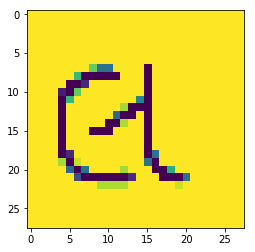

In [15]:
plt.imshow(X_trn[0, :, :])

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [17]:
from data.data_utils import BatchingForMatching

TrnData = BatchingForMatching(X_trn, y_trn, cache_size=4)
ValData = BatchingForMatching(X_val, y_val, cache_size=4)